In [1]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import matrix_power as mpow
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Xi_l = -10
Xi_r = 10
dXi = 0.1
dTau = 0.005
tauMax = 10

size = int((Xi_r - Xi_l) / dXi)
Xi = np.linspace(Xi_l, Xi_r, size, endpoint=True)

# Settings for the plots
num_rows_plot = 4
Pit = np.random.uniform(
    0, tauMax, num_rows_plot**2
)  # random points in time for plotting
Pit = np.sort(Pit)
Iit = Pit / dTau  # Indices of time points
Iit = Iit.astype(int)  # Indices as integers

steps = np.diff(Iit)  # steps between time points

# A1
## a)

remove all dimensions from the schrödinger equation

\begin{equation}
i\hbar \partial_t\psi(x,t)=\left(-\frac{\hbar^2}{2m} \vec{\nabla}^2+\frac{1}{2}m\omega^2x^2 \right)\psi(x,t)=\hat{H}\psi(x,t) \tag{1}
\end{equation}

take out $\frac{\omega \hbar}{2}$ from right hand side:

\begin{equation}
i\hbar \partial_t\psi(x,t)=\frac{\omega \hbar}{2}\left(-\frac{\hbar}{m\omega} \vec{\nabla}^2+\frac{m\omega}{\hbar}x^2 \right)\psi(x,t)=\hat{H}\psi(x,t)  \tag{2}
\end{equation}

We divide above equation by $\hbar$. Then, introducing  $\alpha^2=\frac{m \omega}{\hbar}$, we get

\begin{equation}
i\partial_t\psi(x,t)=\frac{\omega}{2}\left(-\frac{1}{\alpha^2} \frac{\partial^2}{\partial x^2} +\alpha^2x^2 \right)\psi(x,t)=\frac{1}{\hbar}\hat{H}\psi(x,t)  \tag{3}
\end{equation}

Multiplying  with   $2/\omega$ and introducing new variables $\xi=\alpha x$, $\tau=\frac{\omega t}{2}$ we get:

\begin{equation}
i\partial_\tau\psi=\left(- \frac{\partial^2}{\partial \xi^2} +\xi^2 \right)\psi=\frac{2}{\hbar\omega} \hat{H}\psi=\hat{\tilde{H}}\psi   \tag{4}
\end{equation}
where $\hat{\tilde{H}}=\frac{2}{\hbar\omega} \hat{H}$. Hence $\beta=\frac{2}{\hbar\omega}$.



## b)
Calculate $S_H$

Our grid has `size = 200` points. $\tilde{H}_{n,m}$ and $S_H$ are a `200x200` matrices.

In [2]:
delta_n_m = np.eye(size)
delta_n_mp1 = np.eye(size, k=-1)  # delta_{n,m+1}
delta_n_mm1 = np.eye(size, k=1)  # delta_{n,m-1}

HamOp = -1 / dXi**2 * (delta_n_mm1 + delta_n_mp1 - 2 * delta_n_m) + Xi**2 * delta_n_m

TimeEcOpIM = 0.5j * dTau * HamOp

TimeEvOp = inv(np.eye(size) + TimeEcOpIM) @ (np.eye(size) - TimeEcOpIM)

## c)
discretize $\psi(\Epsilon,t=0)$

In [3]:
Xi_0 = 1
psi_0 = np.power(1 / (2 * np.pi), 0.25) * np.exp(-0.25 * (Xi - Xi_0) ** 2)
psi_0 /= norm(psi_0)  # normalization

## d)
calculate $\psi_n(\tau=10)$

In [4]:
psis1 = [psi_0]
for i in range(len(steps)):
    psis1.append(mpow(TimeEvOp, steps[i]) @ psis1[-1])

(0.0, 1.25)

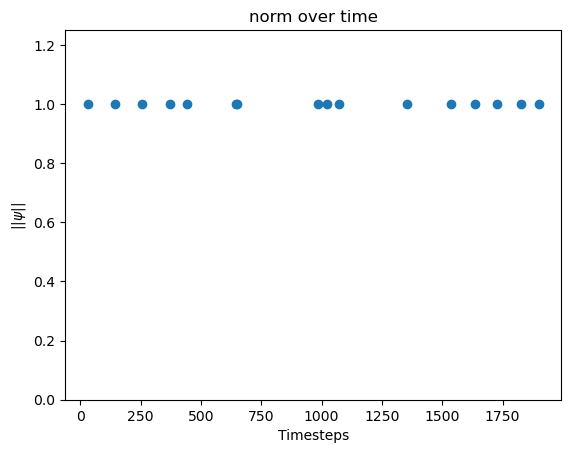

In [5]:
plt.plot(Iit, norm(psis1, axis=1), linestyle="none", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("$||\psi||$ ")
plt.title("norm over time")
plt.ylim(0, 1.25)

The normalization is still satisfied.

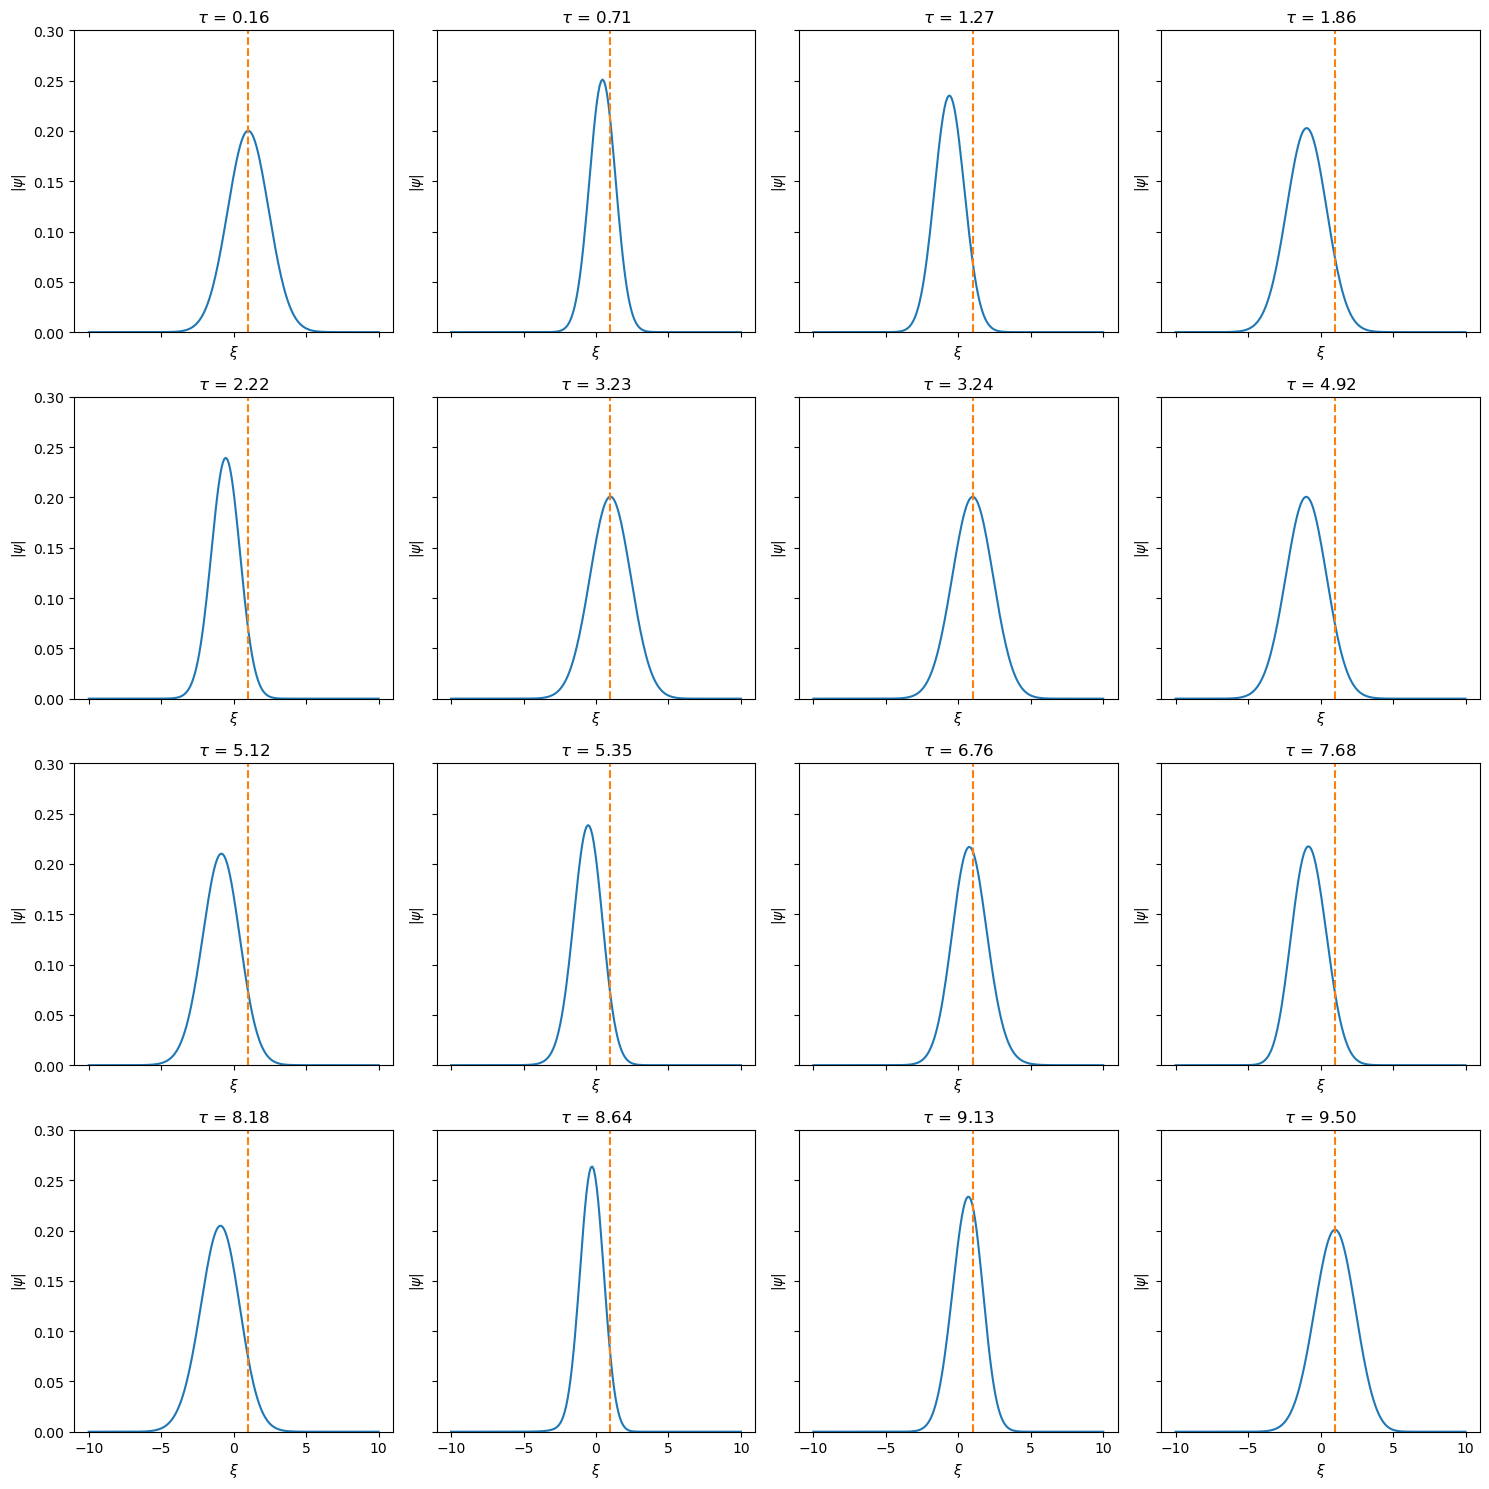

In [6]:
def plot_psis(psis, title=None, ylim=(0, 0.3)):
    fig, ax = plt.subplots(
        num_rows_plot, num_rows_plot, figsize=(15, 15), sharex=True, sharey=True
    )
    if title:
        fig.suptitle(title)
    for i, phi in enumerate(psis):
        row = i // num_rows_plot
        col = i % num_rows_plot
        ax[row, col].plot(Xi, np.abs(phi))
        ax[row, col].set_title(rf"$\tau$ = {Pit[i]:.2f}")
        ax[row, col].set_xlabel(r"$\xi$")
        ax[row, col].set_ylabel(r"$|\psi|$")
        ax[row, col].set_ylim(ylim)
        ax[row, col].axvline(x=Xi_0, linestyle="--", color="tab:orange")

    fig.tight_layout()


plot_psis(psis1)

Note that the orange line is the mean value of the initial state

## e)

calculate the mean value and the variance of the position and momentum.

Plot and discuss the classic background and the Heisenberg's uncertainty principle

In [7]:
psis2 = np.array([psi_0])
for i in range(int(tauMax / dTau)):
    psis2 = np.append(psis2, [TimeEvOp @ psis2[-1]], axis=0)

pos_density = np.abs(psis2) ** 2
pos_mean = np.sum(Xi * pos_density, axis=1)
pos_var = np.sum((Xi - pos_mean[:, np.newaxis]) ** 2 * pos_density, axis=1)

# Momentum space
psi_mom = np.fft.fft(psis2, axis=1)
psi_mom = np.fft.fftshift(psi_mom, axes=1)
psi_mom /= norm(psi_mom, axis=1)[:, np.newaxis]
p = np.fft.fftfreq(size, d=dXi)
p = np.fft.fftshift(p)

mom_density = np.abs(psi_mom) ** 2
mom_mean = np.sum(p * mom_density, axis=1)
mom_var = np.sum((p - mom_mean[:, np.newaxis]) ** 2 * mom_density, axis=1)

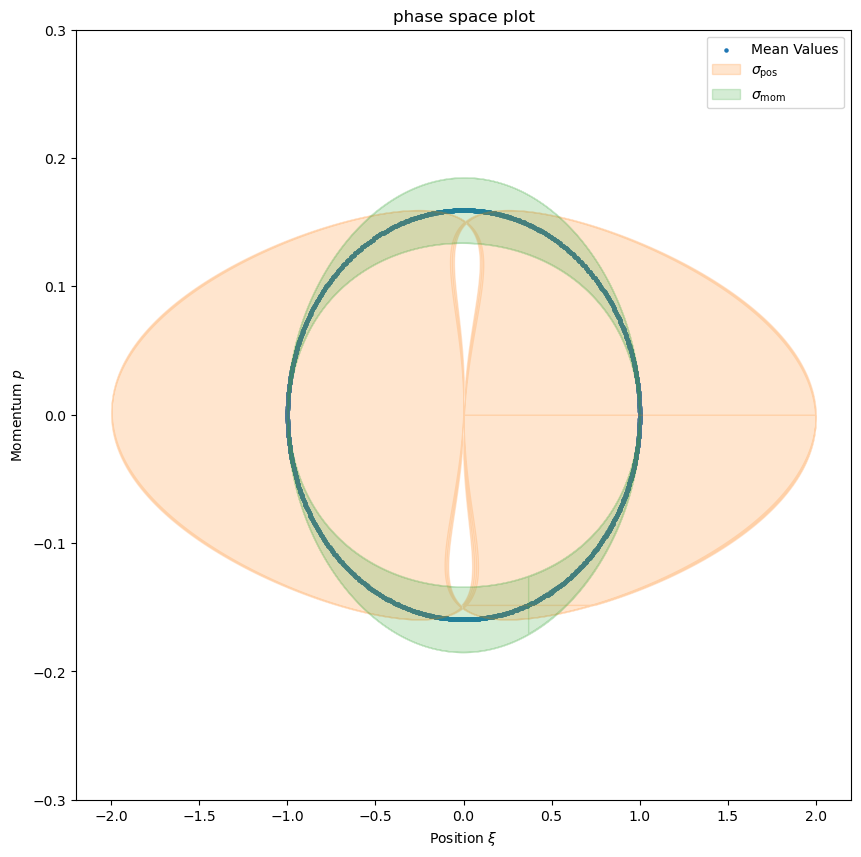

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(pos_mean, mom_mean, color="tab:blue", label="Mean Values", s=5)

# Create translucent fields for the one sigma area
plt.fill_betweenx(
    mom_mean,
    pos_mean - pos_var,
    pos_mean + pos_var,
    color="tab:orange",
    alpha=0.2,
    label="$\sigma_\mathrm{pos}$",
)
plt.fill_between(
    pos_mean,
    mom_mean - mom_var,
    mom_mean + mom_var,
    color="tab:green",
    alpha=0.2,
    label="$\sigma_\mathrm{mom}$",
)
plt.xlabel(r"Position $\xi$")
plt.ylabel("Momentum $p$")
plt.legend()
plt.ylim(-0.3, 0.3)


# Show the plot
plt.title("phase space plot")
plt.show()

You can see the uncertainty principle in this plot. When the position of the particle is well known, so the orange area is small, the variance of the momentum is maxed. Also you can see that the phase space trajectory is a ellipse, as one would expect. Please note the different scales in $x$ and $y$, so we don't have a circle. 

## f)
Do the same for a different initial state

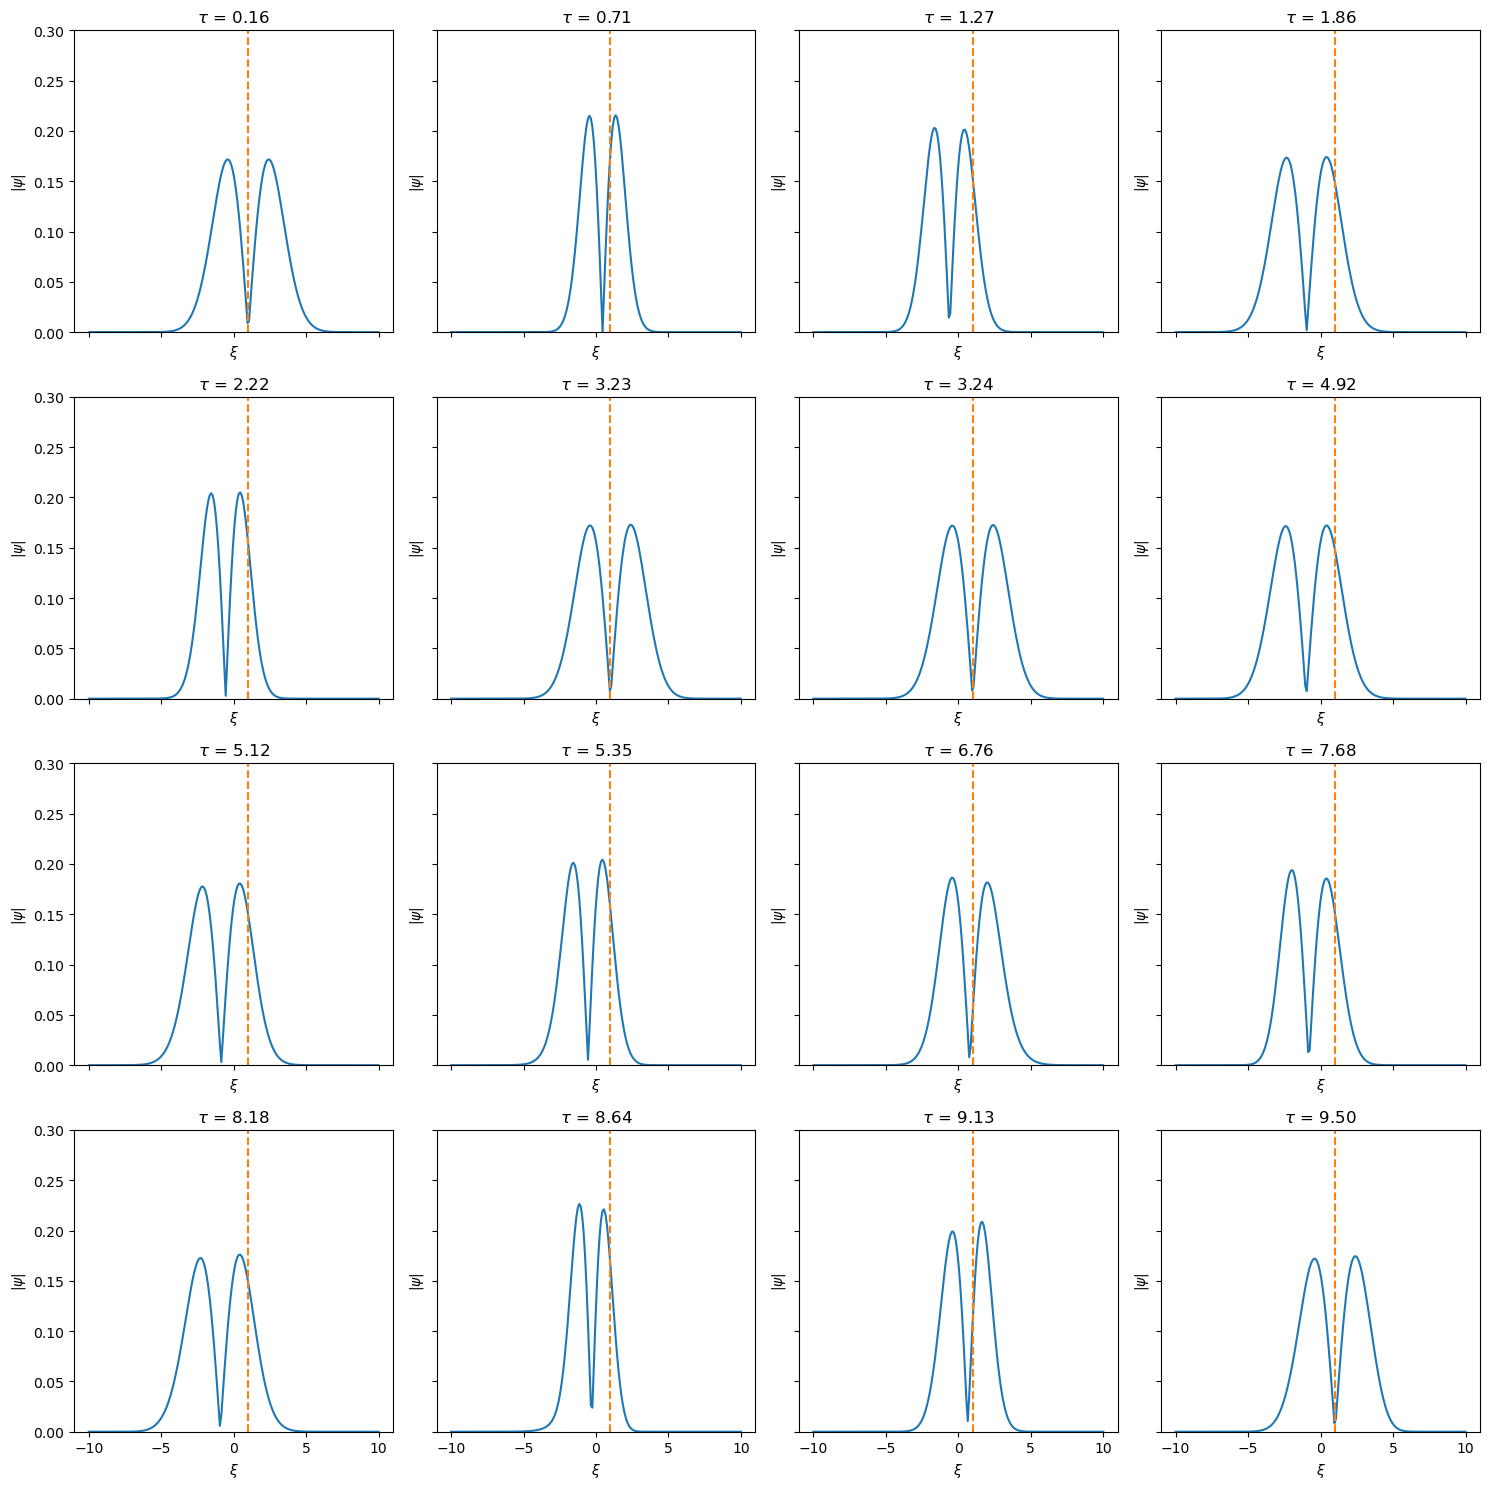

In [9]:
psi_0f = psi_0 * (Xi - Xi_0)
psi_0f /= norm(psi_0f)
psis2 = [psi_0f]
for i in range(len(steps)):
    psis2.append(mpow(TimeEvOp, steps[i]) @ psis2[-1])

plot_psis(psis2)

While the general shape is different between the two initial states, the time evolution is the same as it should be. If you trace the mean value in both plots, you see the same movement. The second initial value seems to have some sort of momentum, as the two peaks are not of equal height, but one can see a leading and a trailing peak.

## g)
use the FTCS method instead

In [10]:
FTCSOp = np.eye(size) - 1j * dTau * HamOp
psisCRNI = [psi_0f]
psisFTCS = [psi_0f]

for i in range(len(steps)):
    psisCRNI.append(mpow(TimeEvOp, steps[i]) @ psisCRNI[-1])
    psisFTCS.append(mpow(FTCSOp, steps[i]) @ psisFTCS[-1])

/tmp/ipykernel_47089/3426456040.py:7: RuntimeWarning: overflow encountered in matmul
  psisFTCS.append(mpow(FTCSOp, steps[i]) @ psisFTCS[-1])
/tmp/ipykernel_47089/3426456040.py:7: RuntimeWarning: invalid value encountered in matmul
  psisFTCS.append(mpow(FTCSOp, steps[i]) @ psisFTCS[-1])


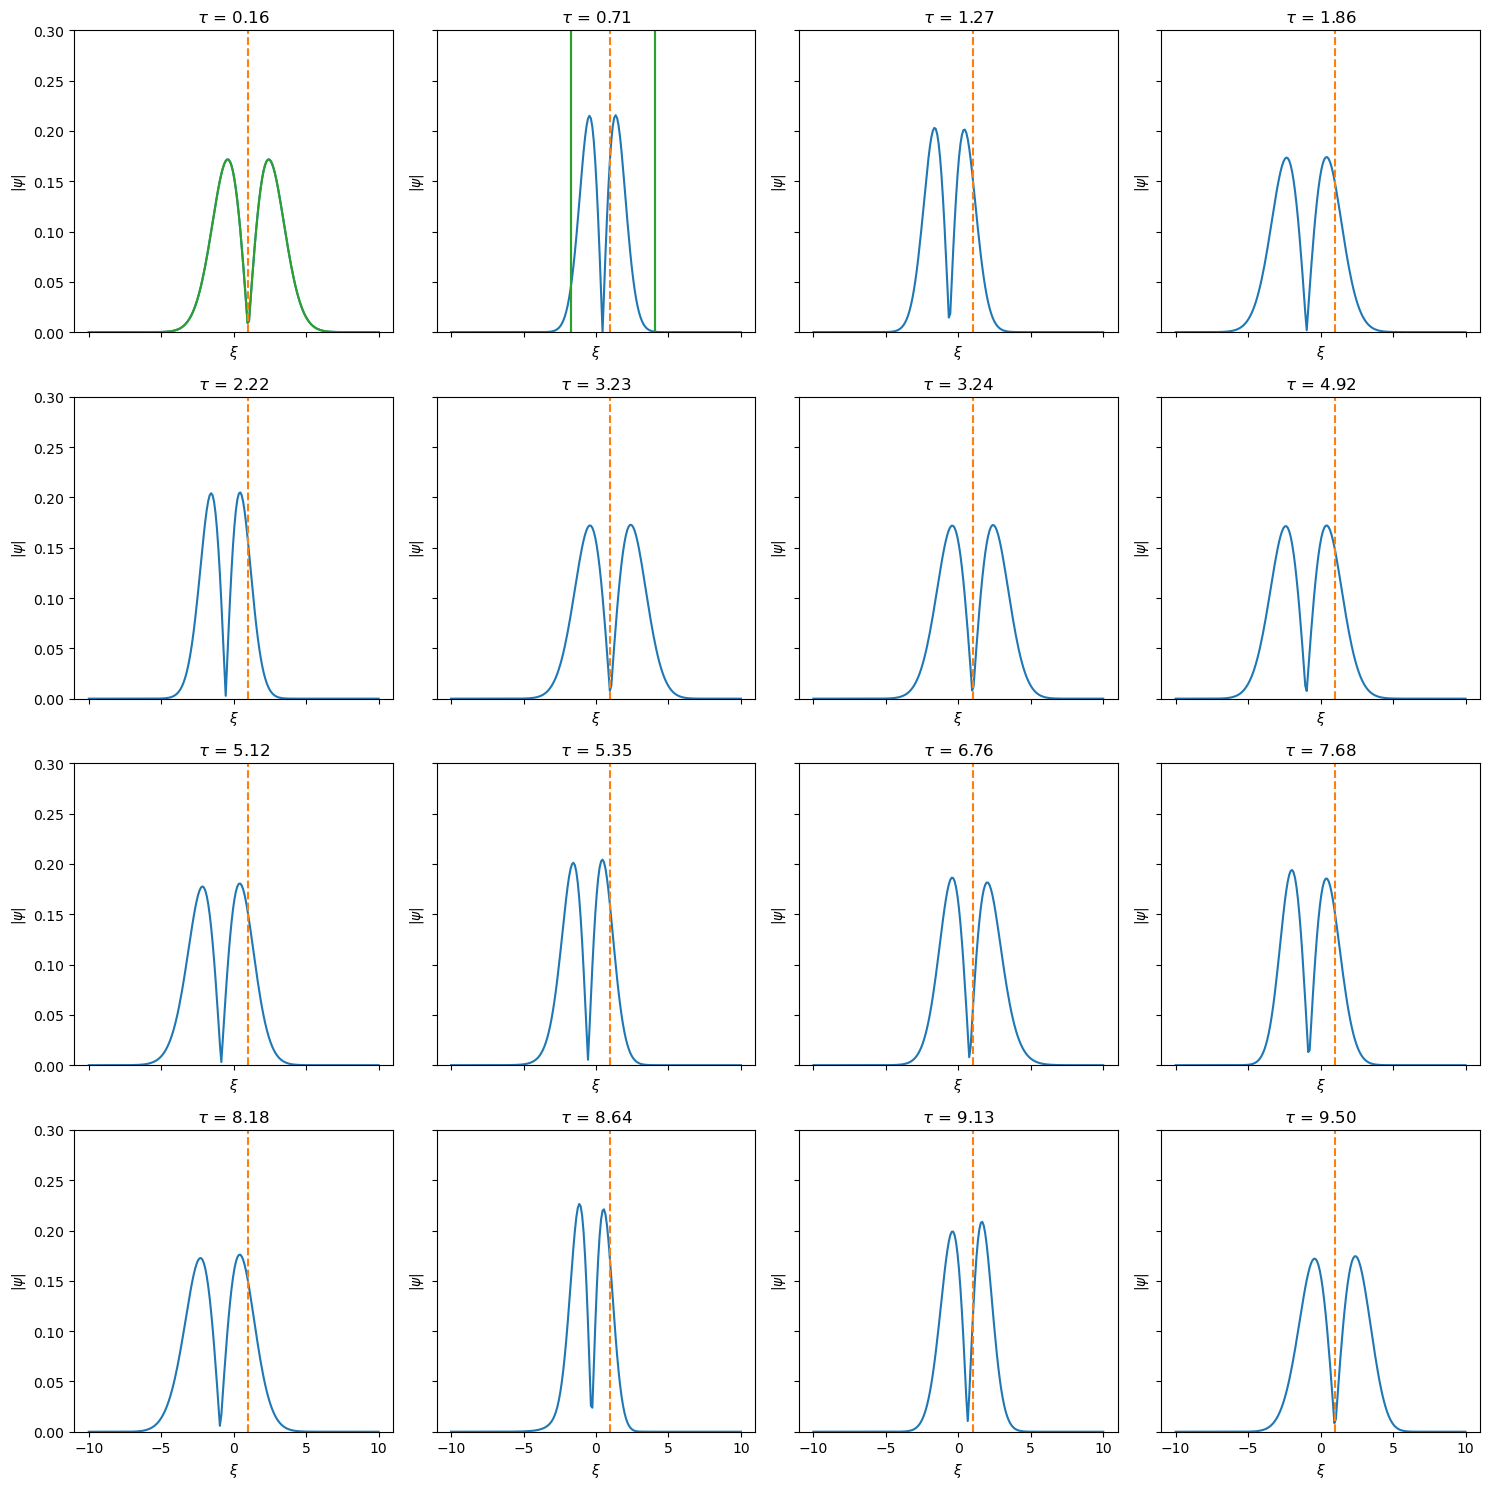

In [11]:
fig, ax = plt.subplots(
    num_rows_plot, num_rows_plot, figsize=(15, 15), sharex=True, sharey=True
)
for i, (NCNI, FTCS) in enumerate(zip(psisCRNI, psisFTCS)):
    row = i // num_rows_plot
    col = i % num_rows_plot
    ax[row, col].plot(Xi, np.abs(NCNI), label="NCNI", color="tab:blue")
    ax[row, col].plot(Xi, np.abs(FTCS), label="FTCS", color="tab:green")
    ax[row, col].set_title(rf"$\tau$ = {Pit[i]:.2f}")
    ax[row, col].set_xlabel(r"$\xi$")
    ax[row, col].set_ylabel(r"$|\psi|$")
    ax[row, col].set_ylim(0, 0.3)
    ax[row, col].axvline(x=Xi_0, linestyle="--", color="tab:orange")
fig.tight_layout()

The FTCS method seams to disappear after a short time. Looking into this,one finds that the values getting extremely big very fast

Text(0.5, 1.0, 'Maximum of $|\\psi|$ using the FTCS method over time')

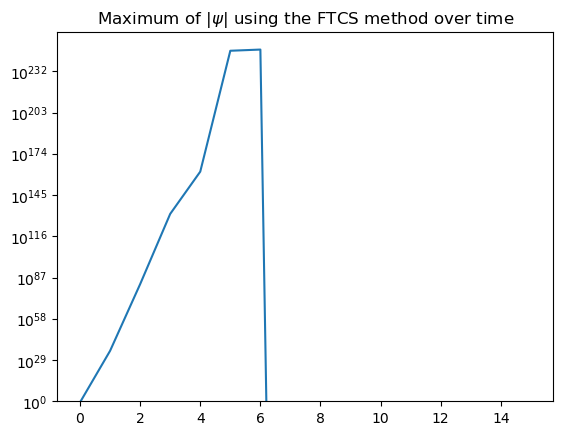

In [12]:
maxes = np.max(np.abs(psisFTCS), axis=1)  # max value of psi for each time step
maxes = np.where(np.isfinite(maxes), maxes, 0)  # filter out infinities and nans
plt.plot(maxes, label="FTCS")
plt.yscale("log")
plt.ylim(1, 1e260)
plt.title("Maximum of $|\psi|$ using the FTCS method over time")

/home/Arch/.local/conda/lib/python3.10/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


Text(0.5, 1.0, 'norm over time, FTCS method')

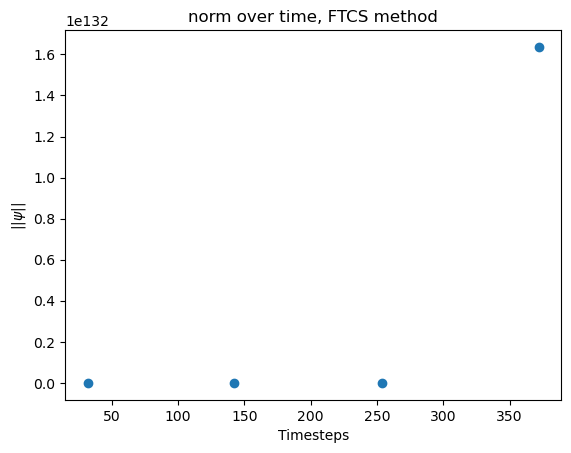

In [13]:
plt.plot(Iit, norm(psisFTCS, axis=1), linestyle="none", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("$||\psi||$ ")
plt.title("norm over time, FTCS method")
# plt.ylim(0, 1.25)

Unsurprisingly, the normalization is also broken with extreme increase in single values.

## h)

Use the CRNI method on a time dependent hamiltonian

$\omega_E = 2\omega$
$\Rightarrow \frac{2\omega_E}{\omega}\tau = 4\tau$

In [14]:
def TimeEvOpH(tau, q, phi0):
    HamOpExt = q * phi0 * Xi * np.cos(4 * tau)
    HamOpH = HamOp + HamOpExt
    TimeEcOpIM = 0.5j * dTau * HamOpH
    return inv(np.eye(size) + TimeEcOpIM) @ (np.eye(size) - TimeEcOpIM)

In [15]:
psis3 = np.array([psi_0])
psis4 = np.array([psi_0])
for tau in tqdm(np.linspace(0, tauMax, int(tauMax / dTau))):
    psis3 = np.append(psis3, [TimeEvOpH(tau, q=2 / 3, phi0=0.5) @ psis3[-1]], axis=0)
    psis4 = np.append(psis4, [TimeEvOpH(tau, q=2, phi0=10) @ psis4[-1]], axis=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

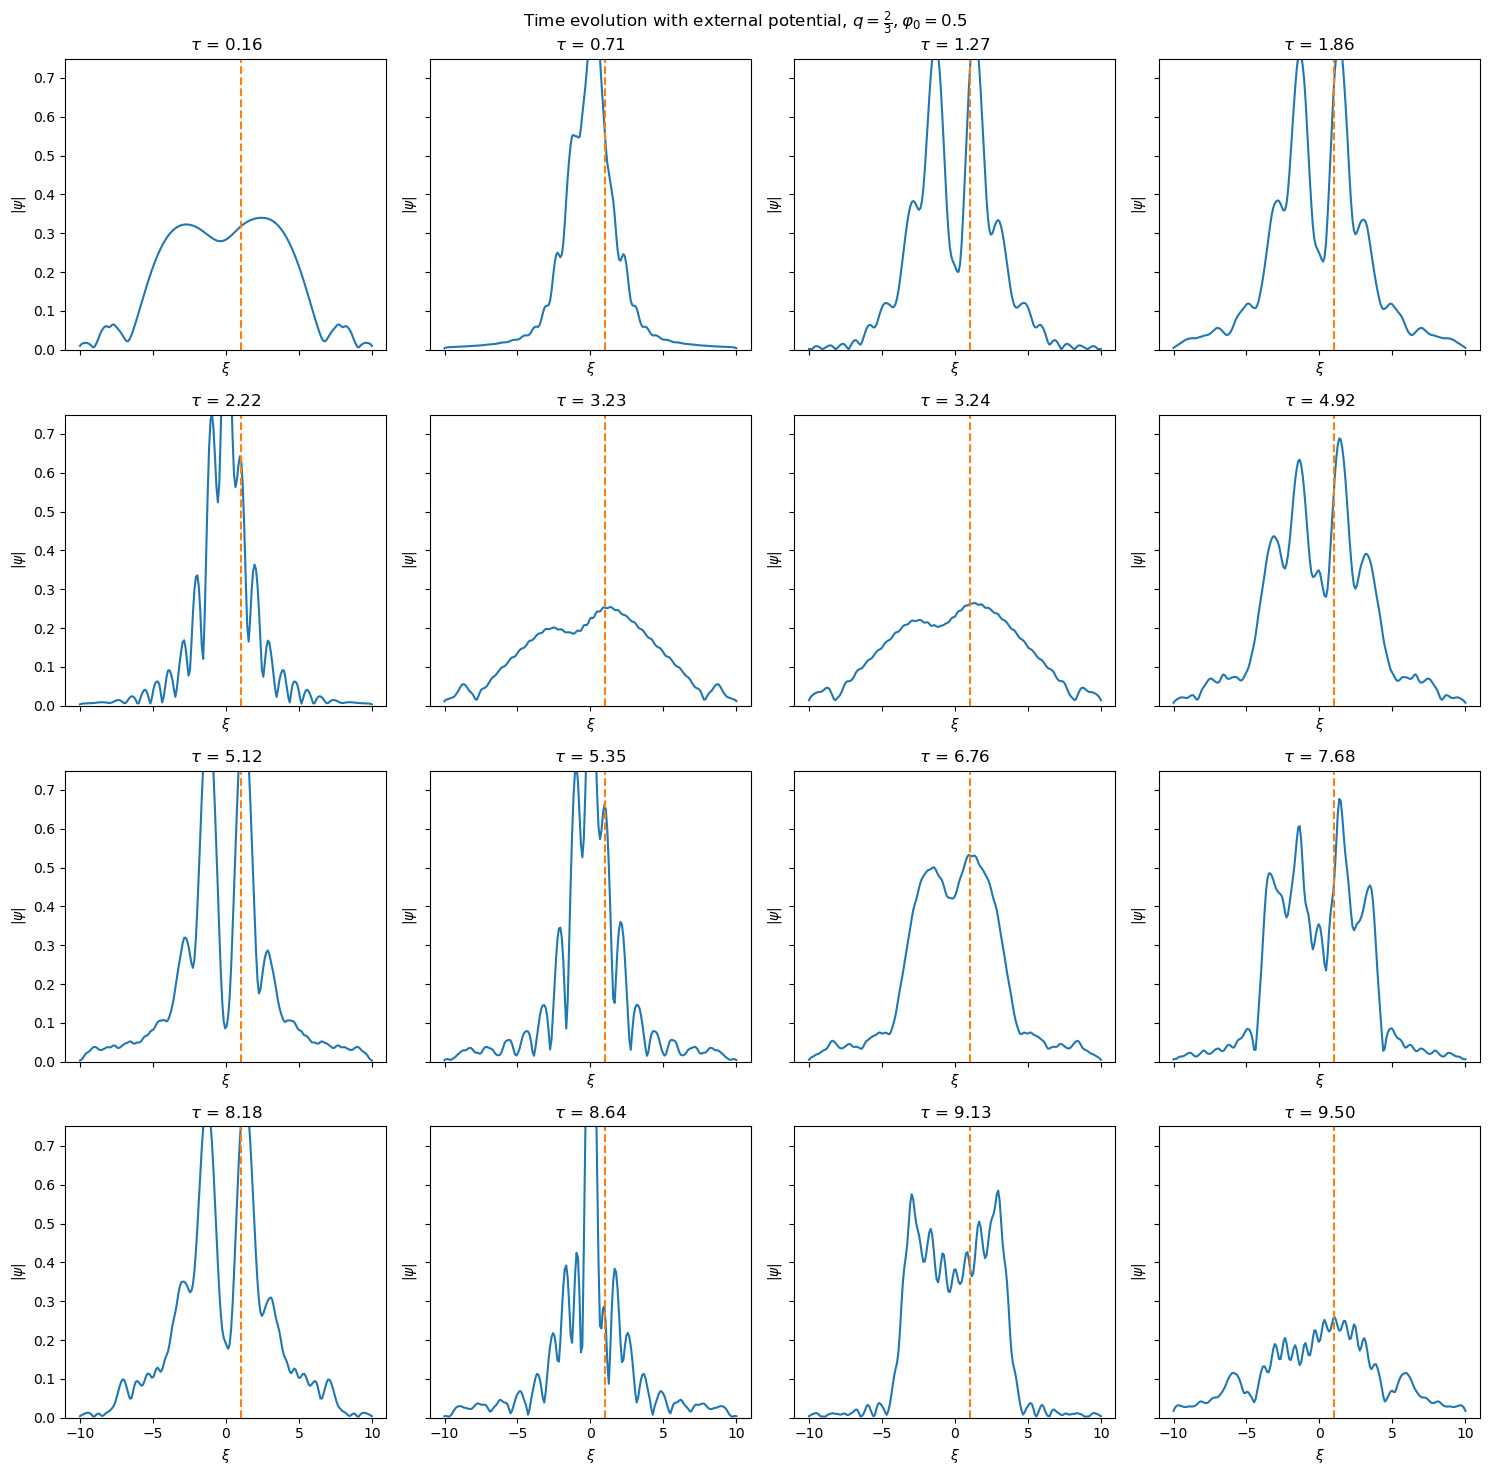

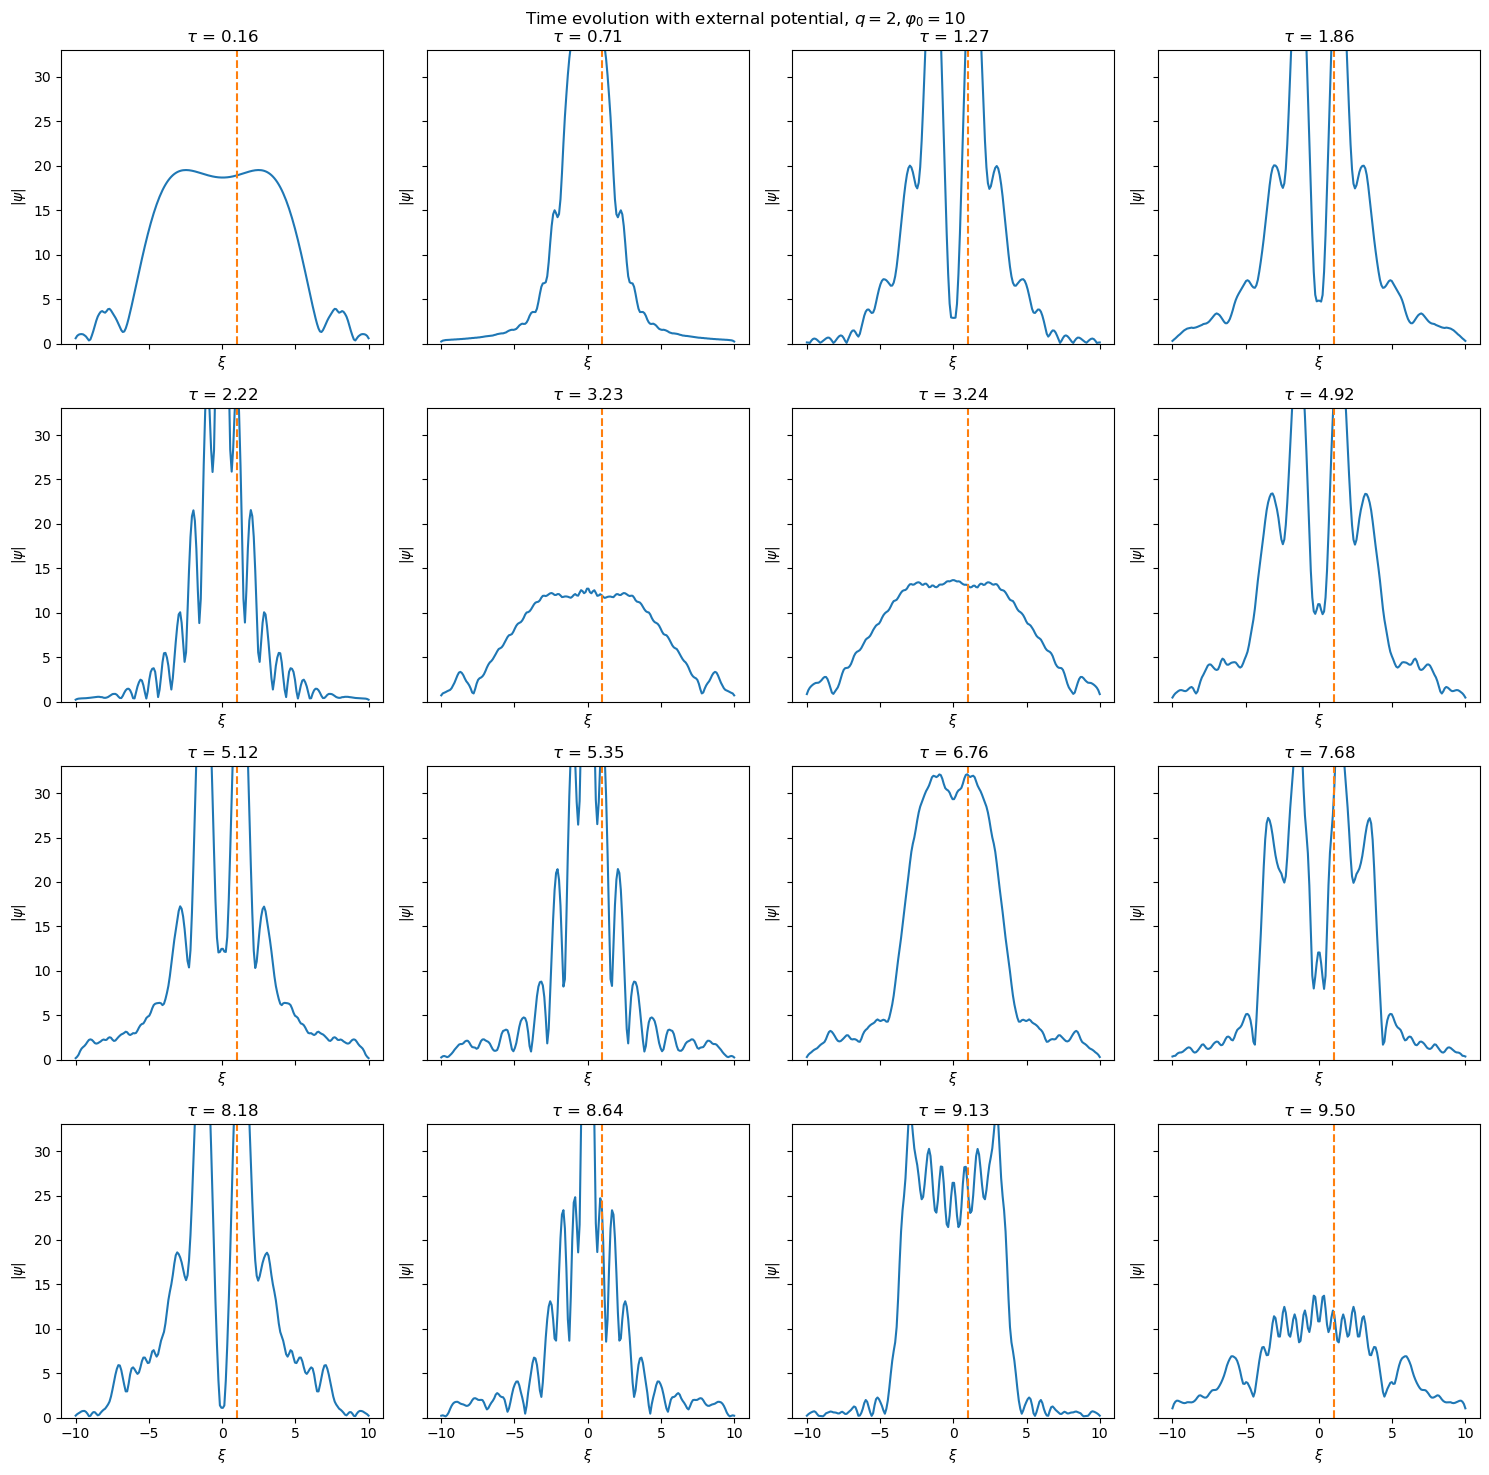

In [16]:
plot_psis(
    psis3[Iit],
    title=r"Time evolution with external potential, $q = \frac{2}{3},\varphi_0 = 0.5$",
    ylim=(0, 0.75),
)
plot_psis(
    psis4[Iit],
    title=r"Time evolution with external potential, $q = 2,\varphi_0 = 10$",
    ylim=(0, 33),
)